Notebook instance: Python3 (Pytorch 1.2 Python 3.8 GPU optimized)

In [2]:
!pip install --upgrade pip
!pip install GPUtil

  Using cached pip-22.3.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2
  Using cached GPUtil-1.4.0-py3-none-any.whl


In [3]:
import os, sys, math
import pandas as pd
import numpy as np
import pickle
import time
import random
import seaborn
import matplotlib.pyplot as plt

import torch
import gc

from GPUtil import showUtilization as gpu_usage
from numba import cuda   

from sklearn.preprocessing import OneHotEncoder

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    gc.collect()
    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()
    
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  1% |  1% |


In [5]:
# peptide alphabet, taken from https://www.cup.uni-muenchen.de/ch/compchem/tink/as.html
pep_alphabet = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 
                'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
#length should be 20
len(pep_alphabet)

20

In [6]:
# Define starting peptide, just random
random.seed(12345)
pep_len = 100
orig_pep = []
for i in range(pep_len):
    orig_pep.append(random.choice(pep_alphabet))
orig_pep = ''.join(orig_pep)
print(orig_pep)
len(orig_pep)

FAIKQHYFEKDFHWEVWEKNTFYTECQNQLLAPLATFAAEYEIDFDYEMGTVLRGDSQWEHYFTCREIACGKWLEMLARRPNMEAKQTDSVRASLVFWQK


100

In [7]:
def generate_ssm_lib(orig_pep, pep_alphabet):
    ssm_lib = []
    for i in range(len(orig_pep)):
        for p in pep_alphabet:
            # generate new peptide with i'th replaced with new letter
            new_pep = ''.join(orig_pep[:i] + p + orig_pep[(i+1):])
            # only append different peptides
            if new_pep != orig_pep:
                ssm_lib.append(new_pep)
    return ssm_lib

ssm_lib = generate_ssm_lib(orig_pep, pep_alphabet)
len(ssm_lib)

1900

In [8]:
!pip install fairscale
!pip install git+https://github.com/facebookresearch/esm.git
!mkdir ESM2/650M/Variable/

  Using cached fairscale-0.4.13-py3-none-any.whl
  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-xq6_h69t
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/esm.git /tmp/pip-req-build-xq6_h69t
  Resolved https://github.com/facebookresearch/esm.git to commit 7c2beef1eb74d8b5744f28ffc215a244d874a74f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fair-esm: filename=fair_esm-2.0.1-py3-none-any.whl size=96076 sha256=405443277d5ee3c055ce0fb660510cc35836d1a22e911265be3c29de91739268
  Stored in directory: /tmp/pip-ephem-wheel-cache-aj8mgwrq/wheels/4d/93/84/94f97c0c2eb9e55cec3d98446534316a88262b407db4c247e7
Successfully built fair-esm
mkdir: cannot create directory ‘ESM2/650M/Variable/’: File exists


In [9]:
from fairscale.nn.data_parallel import FullyShardedDataParallel as FSDP
from fairscale.nn.wrap import enable_wrap, wrap
import esm

In [10]:
# Load ESM-2 650M parameter model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()

In [11]:
i = 0
while i < len(ssm_lib):
    print(i)
    
    gc.collect()
    torch.cuda.empty_cache()
    
    #Subset data into a batch of 100 to get embeddings
    data_subset = []
    for k in range(i, i + 100):
        data_subset.append((str(k), ssm_lib[k]))
    
    #Run the model and extract embeddings on batches of 500
    batch_labels, batch_strs, batch_tokens = batch_converter(data_subset)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=False)
        
    data_ESM2_650M = []

    for j in range(0,len(results['representations'][33])):
        embedding = pd.DataFrame(results['representations'][33][j].cpu().numpy()).iloc[:, :]
        data_ESM2_650M.append(embedding)
    
    filename = "ESM2/650M/Variable/" + str(i) + "_to_" + str(i+100) + "_batch_ESM2_650M_encoding.pkl"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'wb') as f:
        pickle.dump(data_ESM2_650M, f)

    i = i + 100

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800


In [12]:
ESM2_650M_variable_final = []

for i in range(0, 1900, 100):
    path = "ESM2/650M/Variable/" + str(i) + "_to_" + str(i+100) + "_batch_ESM2_650M_encoding.pkl"    
    encoding_file = open(path, "rb")
    features = pickle.load(encoding_file)  
    for embedding in features:
        ESM2_650M_variable_final.append(embedding)

filename = "ESM2/Variable_length_embeddings/ESM2_650M_embedding_variable.pkl"
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'wb') as f:
    pickle.dump(ESM2_650M_variable_final, f)

In [13]:
all_embeddings = pd.read_pickle(filename)
print(type(all_embeddings))

<class 'list'>


In [14]:
len(all_embeddings)

1900

In [15]:
all_embeddings[0]

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,0.036581,0.047350,0.092524,0.043350,0.014192,0.049848,0.089091,-0.055417,-0.074155,-0.033851,...,-0.017149,-0.050264,-0.129618,0.046565,0.005959,0.043642,0.038703,-0.304967,0.174010,-0.044998
1,-0.017015,0.107056,-0.074940,-0.012465,0.026488,-0.016195,0.177209,-0.068330,0.155612,-0.067955,...,-0.060499,0.062441,-0.021852,0.177845,0.070050,0.208815,-0.185681,-0.024854,-0.093418,-0.035095
2,0.021694,0.253016,-0.199430,-0.024588,0.003027,0.161501,-0.021293,0.097416,0.008960,-0.237604,...,0.086280,0.068401,-0.051700,0.099251,0.023959,0.253555,0.148256,-0.037373,-0.154189,0.017390
3,-0.000795,0.200245,-0.186160,0.006325,-0.047684,-0.005846,-0.115776,0.069959,0.062033,-0.327396,...,0.044398,0.320066,0.043706,0.086921,0.155760,0.101733,0.075464,-0.073973,0.089303,-0.000345
4,0.000913,0.098839,-0.073983,-0.048947,-0.157283,0.075593,-0.127463,0.258409,0.075003,-0.049834,...,0.071483,-0.069472,-0.092787,0.026740,0.053380,0.012544,0.133020,-0.178231,-0.223506,-0.119615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.096671,0.084553,-0.023533,0.059182,-0.286219,0.086685,-0.083796,0.196585,0.135692,-0.184023,...,-0.071129,-0.009025,0.185851,0.155612,-0.011412,0.136008,0.209793,-0.042822,-0.136982,-0.106243
98,0.064004,0.118481,-0.002955,0.099033,-0.156968,0.025854,-0.077394,0.127885,0.048879,-0.231803,...,0.024609,-0.107454,0.016356,0.084921,0.162472,0.110737,0.111414,-0.088668,-0.315528,-0.049303
99,-0.054987,-0.045255,0.095286,0.188236,-0.087184,-0.040848,-0.009494,0.198351,0.085961,0.033912,...,0.028072,0.000797,-0.013867,0.089377,-0.019063,0.219491,0.042908,-0.031639,-0.158841,0.099609
100,0.008757,0.046123,-0.068028,0.189504,-0.344327,0.043341,-0.064643,0.196766,0.157914,-0.063482,...,0.068557,0.027906,-0.133659,-0.023238,0.101977,-0.048656,0.087176,0.005192,-0.219649,0.091477


In [16]:
type(all_embeddings[0])

pandas.core.frame.DataFrame

In [17]:
embedding_means = []
for i in range(len(all_embeddings)):
    embedding_means.append(all_embeddings[i].mean(axis = 0))
embedding_means[0]

0       0.056256
1       0.035288
2      -0.030975
3       0.043706
4      -0.061350
          ...   
1275    0.096144
1276    0.064267
1277   -0.006722
1278   -0.087425
1279   -0.029749
Length: 1280, dtype: float32

In [18]:
embedding_means = pd.DataFrame(embedding_means)
embedding_means.shape

(1900, 1280)

In [19]:
from scipy.spatial.distance import pdist

pairwise_embedded_dists = pdist(embedding_means, metric = 'euclidean')

In [20]:
len(pairwise_embedded_dists)

1804050

In [21]:
1900*1899/2

1804050.0

<ipython-input-22-61e3fc3d0cd3>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seaborn.distplot(pairwise_embedded_dists)


<AxesSubplot: ylabel='Density'>

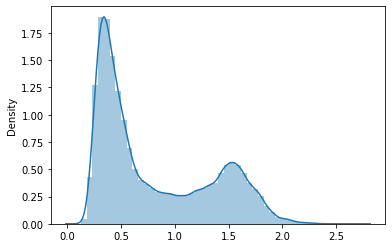

In [22]:
seaborn.distplot(pairwise_embedded_dists)

In [23]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
def one_hot_vec(aa):
    aa_seq_list = []
    for i in aa:
        aa_seq_list.append(i)
    aa_seq_df = pd.DataFrame({"aa": aa_seq_list})
    aa_seq_transformed = ohe.fit_transform(aa_seq_df[['aa']])
    aa_seq_transformed.shape
    ohe_vec = pd.DataFrame(aa_seq_transformed.toarray()).to_numpy().flatten()
    return ohe_vec

ohe_vec = []
for aa in ssm_lib:
    ohe_vec.append(one_hot_vec(aa))

In [24]:
len(ohe_vec)

1900

In [25]:
ohe_vec[0]

array([1., 0., 0., ..., 0., 0., 0.])

In [26]:
pairwise_ohe_dists = pdist(ohe_vec, metric = 'euclidean')

<ipython-input-27-145acbe57ef0>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seaborn.distplot(pairwise_ohe_dists)


<AxesSubplot: ylabel='Density'>

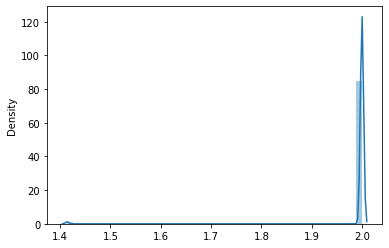

In [27]:
seaborn.distplot(pairwise_ohe_dists)

In [28]:
random_peps = []
for i in range(len(ssm_lib)):
    pep = []
    for j in range(pep_len):
        pep.append(random.choice(pep_alphabet))
    random_peps.append(''.join(pep))

In [29]:
random_peps[0]

'DWCNSELGQEEICWNTACASEVDHTMNPFEGEAKLEMEEYTGFTFLDNPQVYQCTGLYICWTRHFRKTWYDNCKRHPKMIPVHISSRHPAGKCANADVQM'

In [30]:
random_peps[1]

'SEHKQILMNVIKRFQENCIGLFQACDTRLMLRGDSCYQHYWKEIRNDTQWTFTATCYWLYEPFPAKAMKWVALSPRLLMICMYVRYDSDDVERRIQTDPS'

In [31]:
i = 0
while i < len(random_peps):
    print(i)
    
    gc.collect()
    torch.cuda.empty_cache()
    
    #Subset data into a batch of 100 to get embeddings
    data_subset = []
    for k in range(i, i + 100):
        data_subset.append((str(k), random_peps[k]))
    
    #Run the model and extract embeddings on batches of 500
    batch_labels, batch_strs, batch_tokens = batch_converter(data_subset)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=False)
        
    data_ESM2_650M = []

    for j in range(0,len(results['representations'][33])):
        embedding = pd.DataFrame(results['representations'][33][j].cpu().numpy()).iloc[:, :]
        data_ESM2_650M.append(embedding)
    
    filename = "ESM2/650M/Variable/" + str(i) + "rand__to_" + str(i+100) + "_batch_ESM2_650M_encoding.pkl"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'wb') as f:
        pickle.dump(data_ESM2_650M, f)

    i = i + 100
    
ESM2_650M_variable_final = []

for i in range(0, 1900, 100):
    path = "ESM2/650M/Variable/" + str(i) + "rand__to_" + str(i+100) + "_batch_ESM2_650M_encoding.pkl"    
    encoding_file = open(path, "rb")
    features = pickle.load(encoding_file)  
    for embedding in features:
        ESM2_650M_variable_final.append(embedding)

filename = "ESM2/Variable_length_embeddings/rand_ESM2_650M_embedding_variable.pkl"
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'wb') as f:
    pickle.dump(ESM2_650M_variable_final, f)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800


<ipython-input-32-c892aa2178d2>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seaborn.distplot(pairwise_rand_ohe_embedded_dists)


<AxesSubplot: ylabel='Density'>

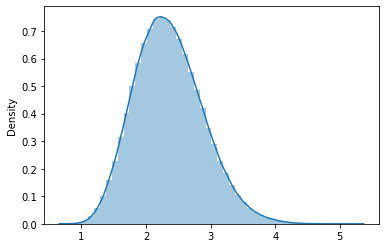

In [32]:
all_ohe_embeddings = pd.read_pickle(filename)
ohe_embedding_means = []
for i in range(len(all_ohe_embeddings)):
    ohe_embedding_means.append(all_ohe_embeddings[i].mean(axis = 0))
pairwise_rand_ohe_embedded_dists = pdist(ohe_embedding_means, metric = 'euclidean')
seaborn.distplot(pairwise_rand_ohe_embedded_dists)

<ipython-input-36-6301a793ec35>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  f = seaborn.kdeplot(dists['random_peptides'], shade = True, color = 'darkred')
<ipython-input-36-6301a793ec35>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  f = seaborn.kdeplot(dists['ssm_peptides'], shade = True, color = 'deepskyblue')


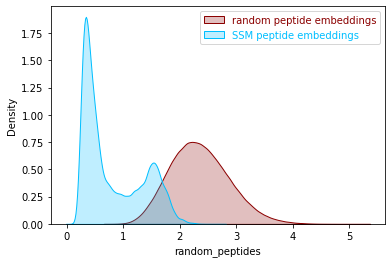

In [36]:
dists = pd.DataFrame({'random_peptides': pairwise_rand_ohe_embedded_dists,
                      'ssm_peptides': pairwise_embedded_dists})
f, ax = plt.subplots(1, 1)
f = seaborn.kdeplot(dists['random_peptides'], shade = True, color = 'darkred')
f = seaborn.kdeplot(dists['ssm_peptides'], shade = True, color = 'deepskyblue')
ax.legend(labels=["random peptide embeddings", "SSM peptide embeddings"], 
          labelcolor = ["darkred", "deepskyblue"])
plt.show()